# LendingClub Credit Risk EDA (FinTech / AI Adjacent)

**Goal:** Understand the dataset, the target (`default_flag`), key drivers of default, and data quality issues.
This notebook intentionally flags **potential leakage** variables (e.g., `paid_*`, `balance`) before modeling.

**Next notebook:** Baseline model (logistic regression + tree/GBM), using only non-leaky features available at origination.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
DATA_PATH = "/Users/samiaibrahim/fintech-credit-decisioning/data/loan50.csv"  # <-- change if needed

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head(3)

(50, 18)


,state,emp_length,term,homeownership,annual_income,verified_income,debt_to_income,total_credit_limit,total_credit_utilized,num_cc_carrying_balance,loan_purpose,loan_amount,grade,interest_rate,public_record_bankrupt,loan_status,has_second_income,total_income
0,NJ,3.0,60,rent,59000,Not Verified,0.557525,95131,32894,8,debt_consolidation,22000,B,10.90,0,Current,False,59000
1,CA,10.0,36,rent,60000,Not Verified,1.305683,51929,78341,2,credit_card,6000,B,9.92,1,Current,False,60000
2,SC,NaN,36,mortgage,75000,Verified,1.056280,301373,79221,14,debt_consolidation,25000,E,26.30,0,Current,False,75000


In [3]:
pd.set_option("display.max_columns", 200)

print("Rows, Cols:", df.shape)
display(df.sample(3, random_state=42))

# column dtypes
display(df.dtypes.value_counts())
display(df.dtypes.sort_values())

# duplicate rows
dup_rows = df.duplicated().sum()
print("Duplicate rows:", dup_rows)

# nulls
nulls = df.isna().mean().sort_values(ascending=False)
display(nulls.head(30))

Rows, Cols: (50, 18)


,state,emp_length,term,homeownership,annual_income,verified_income,debt_to_income,total_credit_limit,total_credit_utilized,num_cc_carrying_balance,loan_purpose,loan_amount,grade,interest_rate,public_record_bankrupt,loan_status,has_second_income,total_income
13,NE,2.0,36,mortgage,105000,Not Verified,0.268190,279386,28160,2,home_improvement,16500,A,5.31,0,Current,False,105000
39,MD,3.0,36,rent,70000,Source Verified,5.333729,272878,373361,2,other,7500,A,7.34,0,Current,False,70000
30,VA,0.0,36,rent,116000,Source Verified,0.584397,446850,67790,7,debt_consolidation,13125,B,10.91,0,Current,False,116000


int64      8
object     6
float64    3
bool       1
Name: count, dtype: int64

has_second_income             bool
total_credit_utilized        int64
public_record_bankrupt       int64
loan_amount                  int64
num_cc_carrying_balance      int64
total_credit_limit           int64
total_income                 int64
annual_income                int64
term                         int64
interest_rate              float64
emp_length                 float64
debt_to_income             float64
verified_income             object
homeownership               object
loan_purpose                object
grade                       object
loan_status                 object
state                       object
dtype: object

Duplicate rows: 0


emp_length                 0.04
state                      0.00
has_second_income          0.00
loan_status                0.00
public_record_bankrupt     0.00
interest_rate              0.00
grade                      0.00
loan_amount                0.00
loan_purpose               0.00
num_cc_carrying_balance    0.00
total_credit_utilized      0.00
total_credit_limit         0.00
debt_to_income             0.00
verified_income            0.00
annual_income              0.00
homeownership              0.00
term                       0.00
total_income               0.00
dtype: float64

In [4]:
df_eda = df.copy()

#target
default_statuses = {
    "Charged Off",
    "Default",
    "Late (31-120 days)"
}

df_eda["default_flag"] = df_eda["loan_status"].isin(default_statuses).astype(int)

#date-ish
if "issue_month" in df_eda.columns:
    df_eda["issue_month"] = pd.to_datetime(df_eda["issue_month"], errors="coerce")

if "earliest_credit_line" in df_eda.columns:
    df_eda["earliest_credit_line"] = pd.to_datetime(df_eda["earliest_credit_line"], errors="coerce")

#numeric coercions (safe)
numeric_candidates = [
    "annual_income","annual_income_joint",
    "debt_to_income","debt_to_income_joint",
    "loan_amount","interest_rate","installment",
    "total_credit_limit","total_credit_utilized","total_debit_limit",
    "delinq_2y","inquiries_last_12m","total_credit_lines","open_credit_lines",
    "num_collections_last_12m","num_historical_failed_to_pay",
    "months_since_last_delinq","months_since_90d_late","months_since_last_credit_inquiry",
    "current_accounts_delinq","total_collection_amount_ever",
    "current_installment_accounts","accounts_opened_24m","num_satisfactory_accounts",
    "num_accounts_120d_past_due","num_accounts_30d_past_due",
    "num_active_debit_accounts","num_total_cc_accounts","num_open_cc_accounts",
    "num_cc_carrying_balance","num_mort_accounts","account_never_delinq_percent",
    "tax_liens","public_record_bankrupt",
    "balance","paid_total","paid_principal","paid_interest","paid_late_fees"
]
for c in numeric_candidates:
    if c in df_eda.columns:
        df_eda[c] = pd.to_numeric(df_eda[c], errors="coerce")

#clean common categoricals
cat_candidates = [
    "state","homeownership","verified_income","verification_income_joint",
    "loan_purpose","application_type","term","grade","sub_grade",
    "loan_status","initial_listing_status","disbursement_method","emp_length","emp_title"
]
for c in cat_candidates:
    if c in df_eda.columns:
        df_eda[c] = df_eda[c].astype("string").str.strip()

default flags 
| loan_status value    | default_flag                      |
| -------------------- | --------------------------------- |
| `Charged Off`        | 1                                 |
| `Default`            | 1                                 |
| `Late (31-120 days)` | 1 *(often included)*              |
| `Current`            | 0                                 |
| `Fully Paid`         | 0                                 |
| `In Grace Period`    | 0 *(or drop, depending on rigor)* |


In [5]:
# Post-origination / outcome-proxy fields (often leakage)
leakage_cols = [c for c in [
    "loan_status",
    "balance",
    "paid_total","paid_principal","paid_interest","paid_late_fees",
] if c in df_eda.columns]

origination_cols = [c for c in df_eda.columns if c not in leakage_cols]

print("Potential leakage cols:", leakage_cols)
print("Origination cols count:", len(origination_cols))

Potential leakage cols: ['loan_status']
Origination cols count: 18


In [6]:
assert "default_flag" in df_eda.columns, "default_flag column missing."

y = df_eda["default_flag"]
print(y.value_counts(dropna=False))
print("Default rate:", float(y.mean()))

default_flag
0    50
Name: count, dtype: int64
Default rate: 0.0


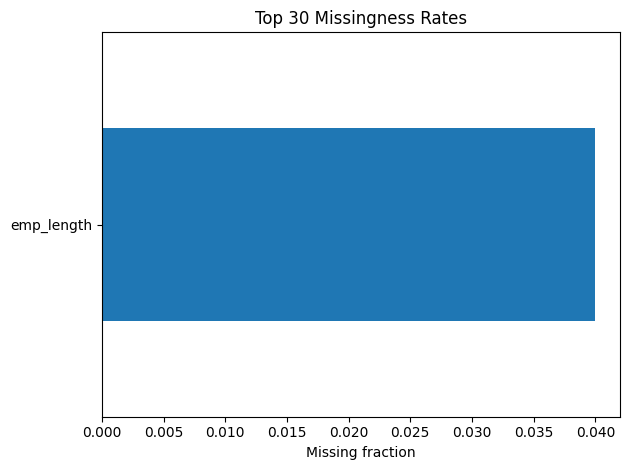

In [7]:
missing = df_eda.isna().mean().sort_values(ascending=False)
missing = missing[missing > 0]

plt.figure()
missing.head(30).sort_values().plot(kind="barh")
plt.title("Top 30 Missingness Rates")
plt.xlabel("Missing fraction")
plt.tight_layout()
plt.show()

Numeric cols: 9


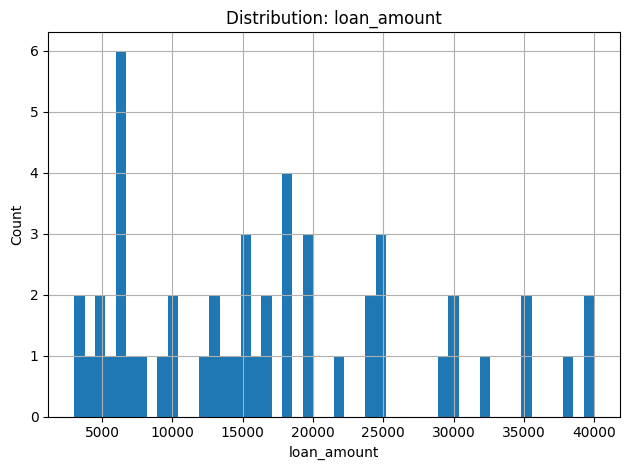

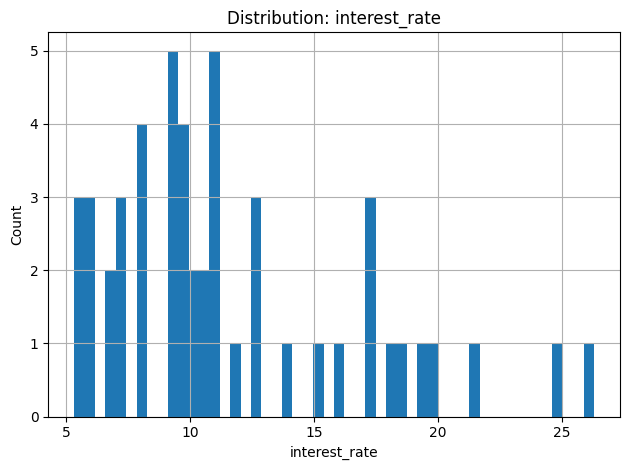

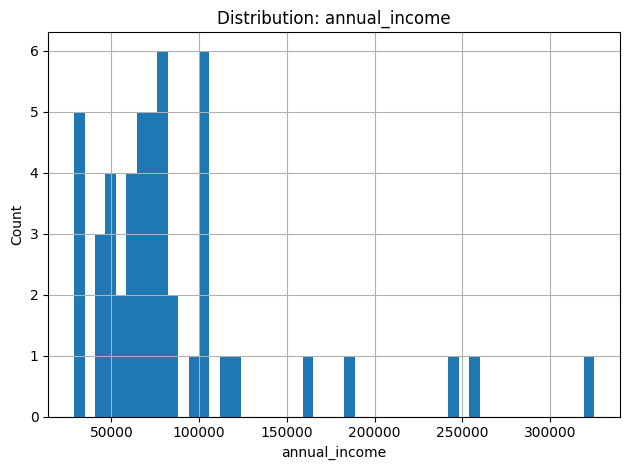

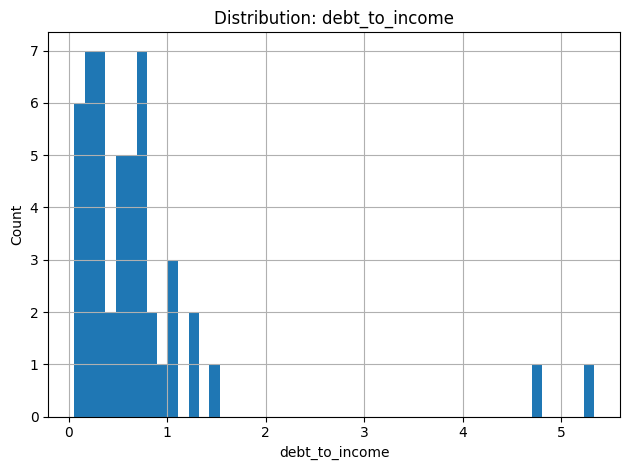

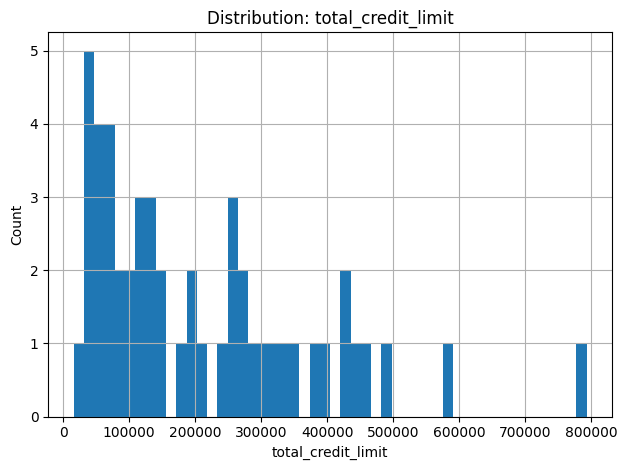

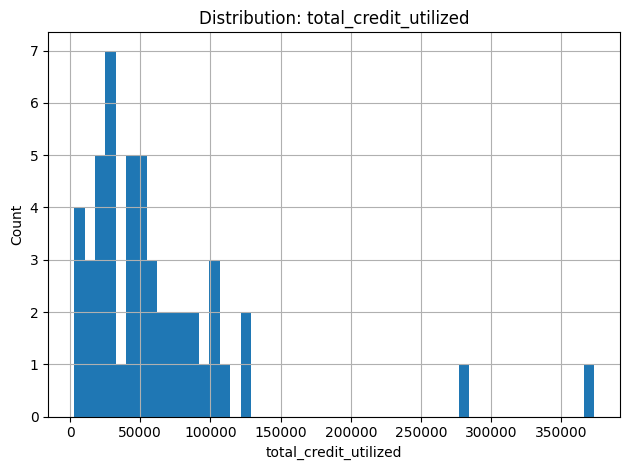

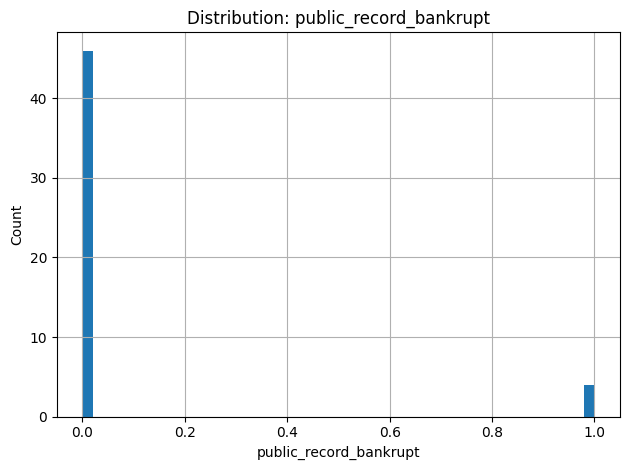

In [8]:
num_cols = df_eda.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != "default_flag"]

print("Numeric cols:", len(num_cols))

# pick a reasonable subset for quick EDA
focus_nums = [c for c in [
    "loan_amount","interest_rate","installment",
    "annual_income","debt_to_income",
    "total_credit_limit","total_credit_utilized",
    "delinq_2y","inquiries_last_12m",
    "num_historical_failed_to_pay",
    "account_never_delinq_percent",
    "public_record_bankrupt","tax_liens"
] if c in df_eda.columns]

for c in focus_nums:
    plt.figure()
    df_eda[c].dropna().hist(bins=50)
    plt.title(f"Distribution: {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [9]:
cat_cols = df_eda.select_dtypes(include=["string"]).columns.tolist()

focus_cats = [c for c in [
    "term","grade","sub_grade","homeownership","verified_income",
    "loan_purpose","application_type","state"
] if c in df_eda.columns]

for c in focus_cats:
    vc = df_eda[c].value_counts(dropna=False).head(20)
    display(pd.DataFrame({c: vc.index.astype(str), "count": vc.values}))

,term,count
0,36,36
1,60,14


,grade,count
0,B,19
1,A,15
2,D,8
3,C,6
4,E,2


,homeownership,count
0,mortgage,26
1,rent,21
2,own,3


,verified_income,count
0,Not Verified,21
1,Source Verified,20
2,Verified,9


,loan_purpose,count
0,debt_consolidation,23
1,credit_card,13
2,home_improvement,5
3,other,4
4,car,2
5,house,1
6,small_business,1
7,renewable_energy,1


,state,count
0,CA,9
1,TX,5
2,IL,4
3,FL,3
4,MD,3
5,NJ,3
6,IN,2
7,HI,2
8,NV,2
9,MA,2


,term,count,default_rate
0,36,36,0.0
1,60,14,0.0


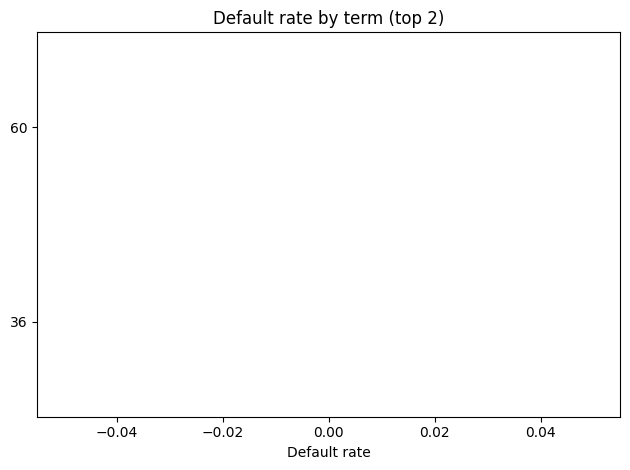

,grade,count,default_rate
1,B,19,0.0
0,A,15,0.0
3,D,8,0.0
2,C,6,0.0
4,E,2,0.0


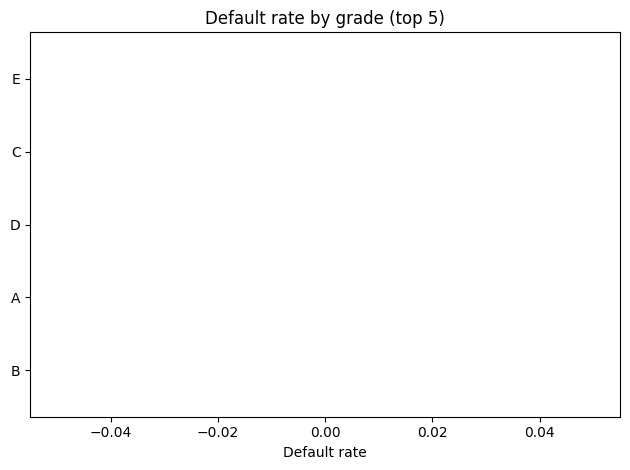

,homeownership,count,default_rate
0,mortgage,26,0.0
2,rent,21,0.0
1,own,3,0.0


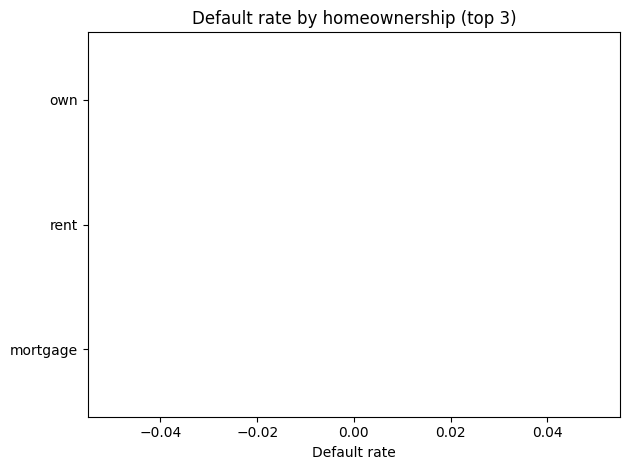

,verified_income,count,default_rate
0,Not Verified,21,0.0
1,Source Verified,20,0.0
2,Verified,9,0.0


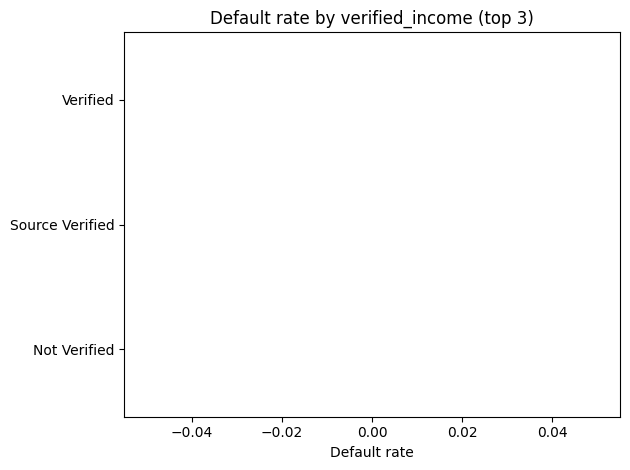

,loan_purpose,count,default_rate
2,debt_consolidation,23,0.0
1,credit_card,13,0.0
3,home_improvement,5,0.0
5,other,4,0.0
0,car,2,0.0
4,house,1,0.0
6,renewable_energy,1,0.0
7,small_business,1,0.0


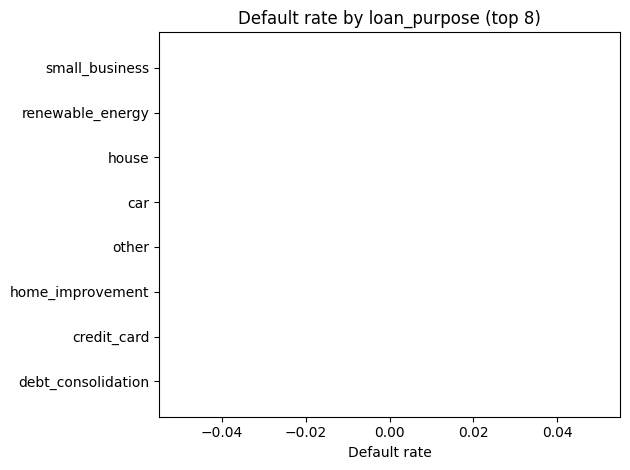

,state,count,default_rate
1,CA,9,0.0
21,TX,5,0.0
5,IL,4,0.0
8,MD,3,0.0
15,NJ,3,0.0
3,FL,3,0.0
7,MA,2,0.0
16,NV,2,0.0
6,IN,2,0.0
4,HI,2,0.0


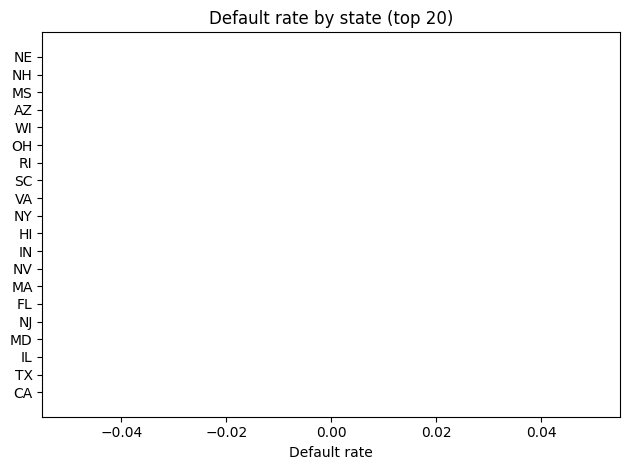

In [10]:
#default rate by key cateogricals 
def default_rate_by(col, top_n=20):
    tmp = df_eda[[col, "default_flag"]].copy()
    tmp[col] = tmp[col].fillna("MISSING")
    agg = tmp.groupby(col)["default_flag"].agg(["count","mean"]).reset_index()
    agg = agg.sort_values("count", ascending=False).head(top_n)
    agg.rename(columns={"mean":"default_rate"}, inplace=True)
    return agg

for c in [x for x in focus_cats if x != "emp_title"]:
    agg = default_rate_by(c, top_n=20)
    display(agg)

    plt.figure()
    plt.barh(agg[c].astype(str), agg["default_rate"])
    plt.title(f"Default rate by {c} (top {len(agg)})")
    plt.xlabel("Default rate")
    plt.tight_layout()
    plt.show()

,bucket,count,default_rate
0,"(5.308999999999999, 6.08]",6,0.0
1,"(6.08, 7.35]",5,0.0
2,"(7.35, 8.992]",4,0.0
3,"(8.992, 9.728]",5,0.0
4,"(9.728, 9.93]",6,0.0
5,"(9.93, 10.904]",4,0.0
6,"(10.904, 12.62]",7,0.0
7,"(12.62, 16.234]",3,0.0
8,"(16.234, 18.547]",5,0.0
9,"(18.547, 26.3]",5,0.0


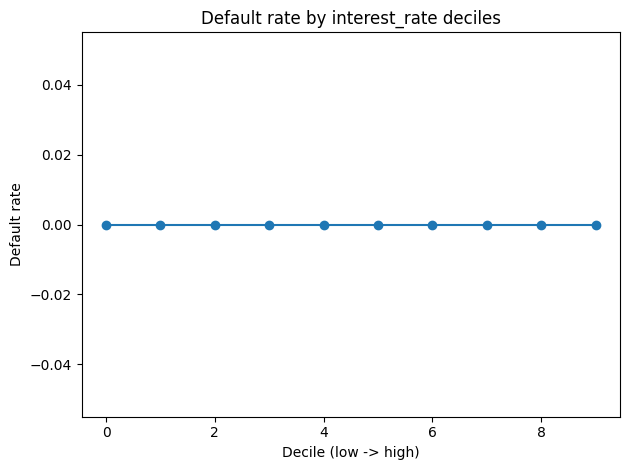

,bucket,count,default_rate
0,"(0.0537, 0.157]",5,0.0
1,"(0.157, 0.244]",5,0.0
2,"(0.244, 0.293]",5,0.0
3,"(0.293, 0.378]",5,0.0
4,"(0.378, 0.54]",5,0.0
5,"(0.54, 0.633]",5,0.0
6,"(0.633, 0.724]",5,0.0
7,"(0.724, 0.803]",5,0.0
8,"(0.803, 1.122]",5,0.0
9,"(1.122, 5.334]",5,0.0


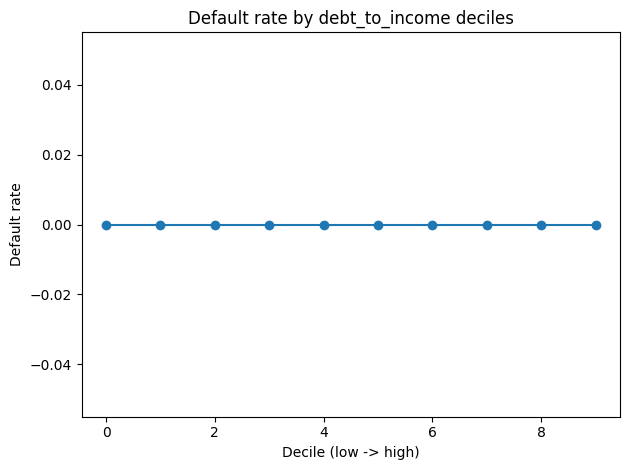

,bucket,count,default_rate
0,"(28799.999, 41200.0]",5,0.0
1,"(41200.0, 50000.0]",7,0.0
2,"(50000.0, 58850.0]",3,0.0
3,"(58850.0, 66200.0]",5,0.0
4,"(66200.0, 74000.0]",5,0.0
5,"(74000.0, 80000.0]",9,0.0
6,"(80000.0, 85600.0]",1,0.0
7,"(85600.0, 100600.0]",5,0.0
8,"(100600.0, 124000.0]",5,0.0
9,"(124000.0, 325000.0]",5,0.0


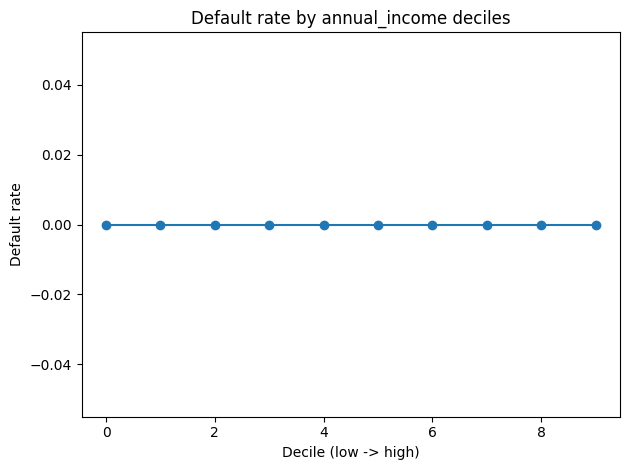

,bucket,count,default_rate
0,"(2999.999, 5742.5]",5,0.0
1,"(5742.5, 6320.0]",5,0.0
2,"(6320.0, 9700.0]",5,0.0
3,"(9700.0, 13350.0]",5,0.0
4,"(13350.0, 15500.0]",5,0.0
5,"(15500.0, 18080.0]",5,0.0
6,"(18080.0, 20600.0]",5,0.0
7,"(20600.0, 25000.0]",6,0.0
8,"(25000.0, 32300.0]",4,0.0
9,"(32300.0, 40000.0]",5,0.0


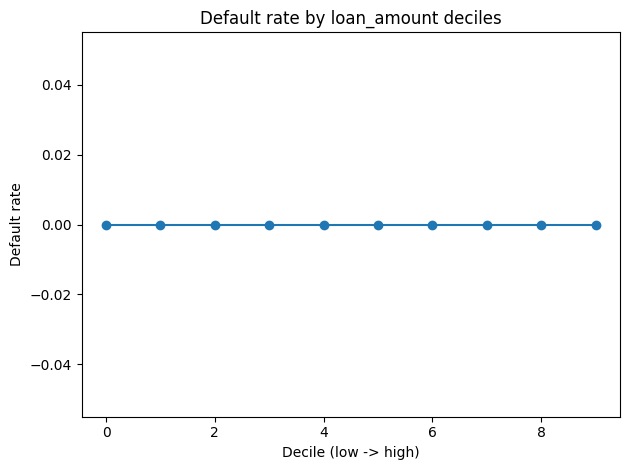

,bucket,count,default_rate
0,"(2871.999, 15582.5]",5,0.0
1,"(15582.5, 23187.4]",5,0.0
2,"(23187.4, 27993.8]",5,0.0
3,"(27993.8, 37760.0]",5,0.0
4,"(37760.0, 48005.5]",5,0.0
5,"(48005.5, 54647.6]",5,0.0
6,"(54647.6, 68331.5]",5,0.0
7,"(68331.5, 88069.8]",5,0.0
8,"(88069.8, 103566.7]",5,0.0
9,"(103566.7, 373361.0]",5,0.0


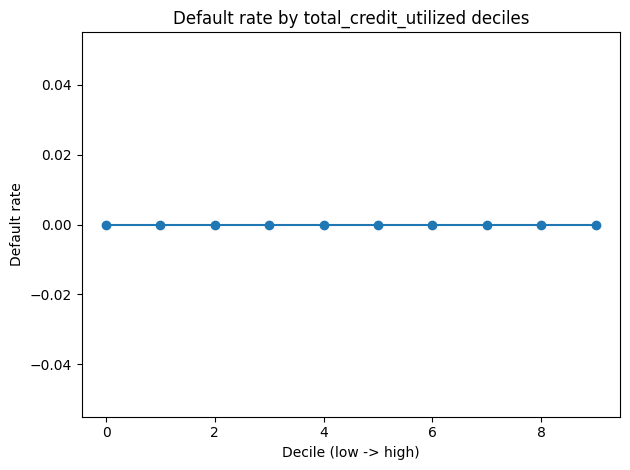

In [11]:
#default rate by numeric buckets
def bucket_default_rate(num_col, bins=10):
    tmp = df_eda[[num_col, "default_flag"]].dropna().copy()
    tmp["bucket"] = pd.qcut(tmp[num_col], q=bins, duplicates="drop")
    agg = tmp.groupby("bucket")["default_flag"].agg(["count","mean"]).reset_index()
    agg.rename(columns={"mean":"default_rate"}, inplace=True)
    return agg

bucket_cols = [c for c in ["interest_rate","debt_to_income","annual_income","loan_amount","total_credit_utilized"] if c in df_eda.columns]

for c in bucket_cols:
    agg = bucket_default_rate(c, bins=10)
    display(agg)

    plt.figure()
    plt.plot(range(len(agg)), agg["default_rate"], marker="o")
    plt.title(f"Default rate by {c} deciles")
    plt.xlabel("Decile (low -> high)")
    plt.ylabel("Default rate")
    plt.tight_layout()
    plt.show()


In [12]:
#time trends issue months 
if "issue_month" in df_eda.columns and df_eda["issue_month"].notna().any():
    tmp = df_eda.dropna(subset=["issue_month"]).copy()
    monthly = tmp.groupby(tmp["issue_month"].dt.to_period("M"))["default_flag"].agg(["count","mean"]).reset_index()
    monthly["issue_month"] = monthly["issue_month"].dt.to_timestamp()
    monthly.rename(columns={"mean":"default_rate"}, inplace=True)

    display(monthly.tail(24))

    plt.figure()
    plt.plot(monthly["issue_month"], monthly["default_rate"])
    plt.title("Default rate over time (by issue_month)")
    plt.xlabel("Issue month")
    plt.ylabel("Default rate")
    plt.tight_layout()
    plt.show()


In [18]:
# credit age (months) from earliest_credit_line -> issue_month
if "earliest_credit_line" in df_eda.columns and "issue_month" in df_eda.columns:
    tmp = df_eda.dropna(subset=["earliest_credit_line","issue_month"]).copy()

    credit_age_days = (tmp["issue_month"] - tmp["earliest_credit_line"]).dt.days
    tmp["credit_age_months"] = credit_age_days / 30.44

    tmp["credit_age_months"] = tmp["credit_age_months"].clip(lower=0, upper=600)

    plt.figure()
    tmp["credit_age_months"].hist(bins=50)
    plt.title("Credit age (months)")
    plt.xlabel("credit_age_months")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # default vs credit age bucket
    tmp2 = tmp[["credit_age_months","default_flag"]].dropna().copy()
    tmp2["bucket"] = pd.qcut(tmp2["credit_age_months"], q=10, duplicates="drop")
    agg = (
        tmp2.groupby("bucket")["default_flag"]
            .agg(["count","mean"])
            .reset_index()
            .rename(columns={"mean":"default_rate"})
    )
    display(agg)



In [14]:
#leakage sanity check
#If these exist, they often "predict default" too well because they reflect outcomes.
leaky_probe = [c for c in leakage_cols if c in df_eda.columns]
if leaky_probe:
    corr = []
    for c in leaky_probe:
        if pd.api.types.is_numeric_dtype(df_eda[c]):
            corr.append((c, df_eda[[c,"default_flag"]].corr(numeric_only=True).iloc[0,1]))
    display(pd.DataFrame(corr, columns=["col","corr_with_default_flag"]).sort_values("corr_with_default_flag", ascending=False))
else:
    print("No leakage-proxy columns detected in this file.")


,col,corr_with_default_flag


In [19]:
import numpy as np
import pandas as pd

def parse_month_year(s: pd.Series) -> pd.Series:
    """
    Parses strings like 'Jan-2014', '2014-01', etc. into Timestamp (month start).
    Tries a couple common formats.
    """
    s = s.astype("string")
    out = pd.to_datetime(s, errors="coerce")  # catches ISO-like cases
    # If many NaT, try LendingClub-style "Mon-YYYY"
    if out.isna().mean() > 0.2:
        out2 = pd.to_datetime(s, format="%b-%Y", errors="coerce")
        out = out.fillna(out2)
    return out.dt.to_period("M").dt.to_timestamp()  # normalize to month start

#Parse dates 
df["issue_dt"] = parse_month_year(df["issue_month"])
df["earliest_credit_dt"] = parse_month_year(df["earliest_credit_line"])

#Month difference (unambiguous) 
def month_diff(later: pd.Series, earlier: pd.Series) -> pd.Series:
    later_p = later.dt.to_period("M")
    earlier_p = earlier.dt.to_period("M")
    return (later_p.dt.year - earlier_p.dt.year) * 12 + (later_p.dt.month - earlier_p.dt.month)

df["credit_history_months"] = month_diff(df["issue_dt"], df["earliest_credit_dt"])

# Optional sanity handling
df.loc[df["credit_history_months"] < 0, "credit_history_months"] = np.nan


KeyError: 'issue_month'

In [17]:
#save EDA output for later 
# Basic profiling tables you might want in the README later
eda_summary = {
    "rows": int(df_eda.shape[0]),
    "cols": int(df_eda.shape[1]),
    "default_rate": float(df_eda["default_flag"].mean()),
}
#/Users/samiaibrahim/fintech-credit-decisioning/data/outputs
pd.Series(eda_summary).to_csv("/Users/samiaibrahim/fintech-credit-decisioning/data/outputs/eda_summary.csv", header=False)
print("Saved: ../outputs/eda_summary.csv")


Saved: ../outputs/eda_summary.csv
